# CGRdb tutorial.
Expected You already done with DB SETUP from README!

In [1]:
import sys
sys.modules['__main__'].__file__ = None  # add-hoc for disable Pony interactive mode.

from CGRdb import load_schema, Reaction, Molecule
from CGRtools import RDFRead, ReactionContainer
from pony.orm import db_session

In [2]:
# replace 'test' with name of schema used in `cgrdb create`
db = load_schema('test', password='password', port=5432, host='localhost', user='postgres')

/home/stsouko/cgrdb/lib/python3.7/site-packages/LazyPony/__init__.py:80: UserWarning: for many-to-many relationship if schema used NEED to define m2m table name
  warn('for many-to-many relationship if schema used NEED to define m2m table name')


# ER Diagram

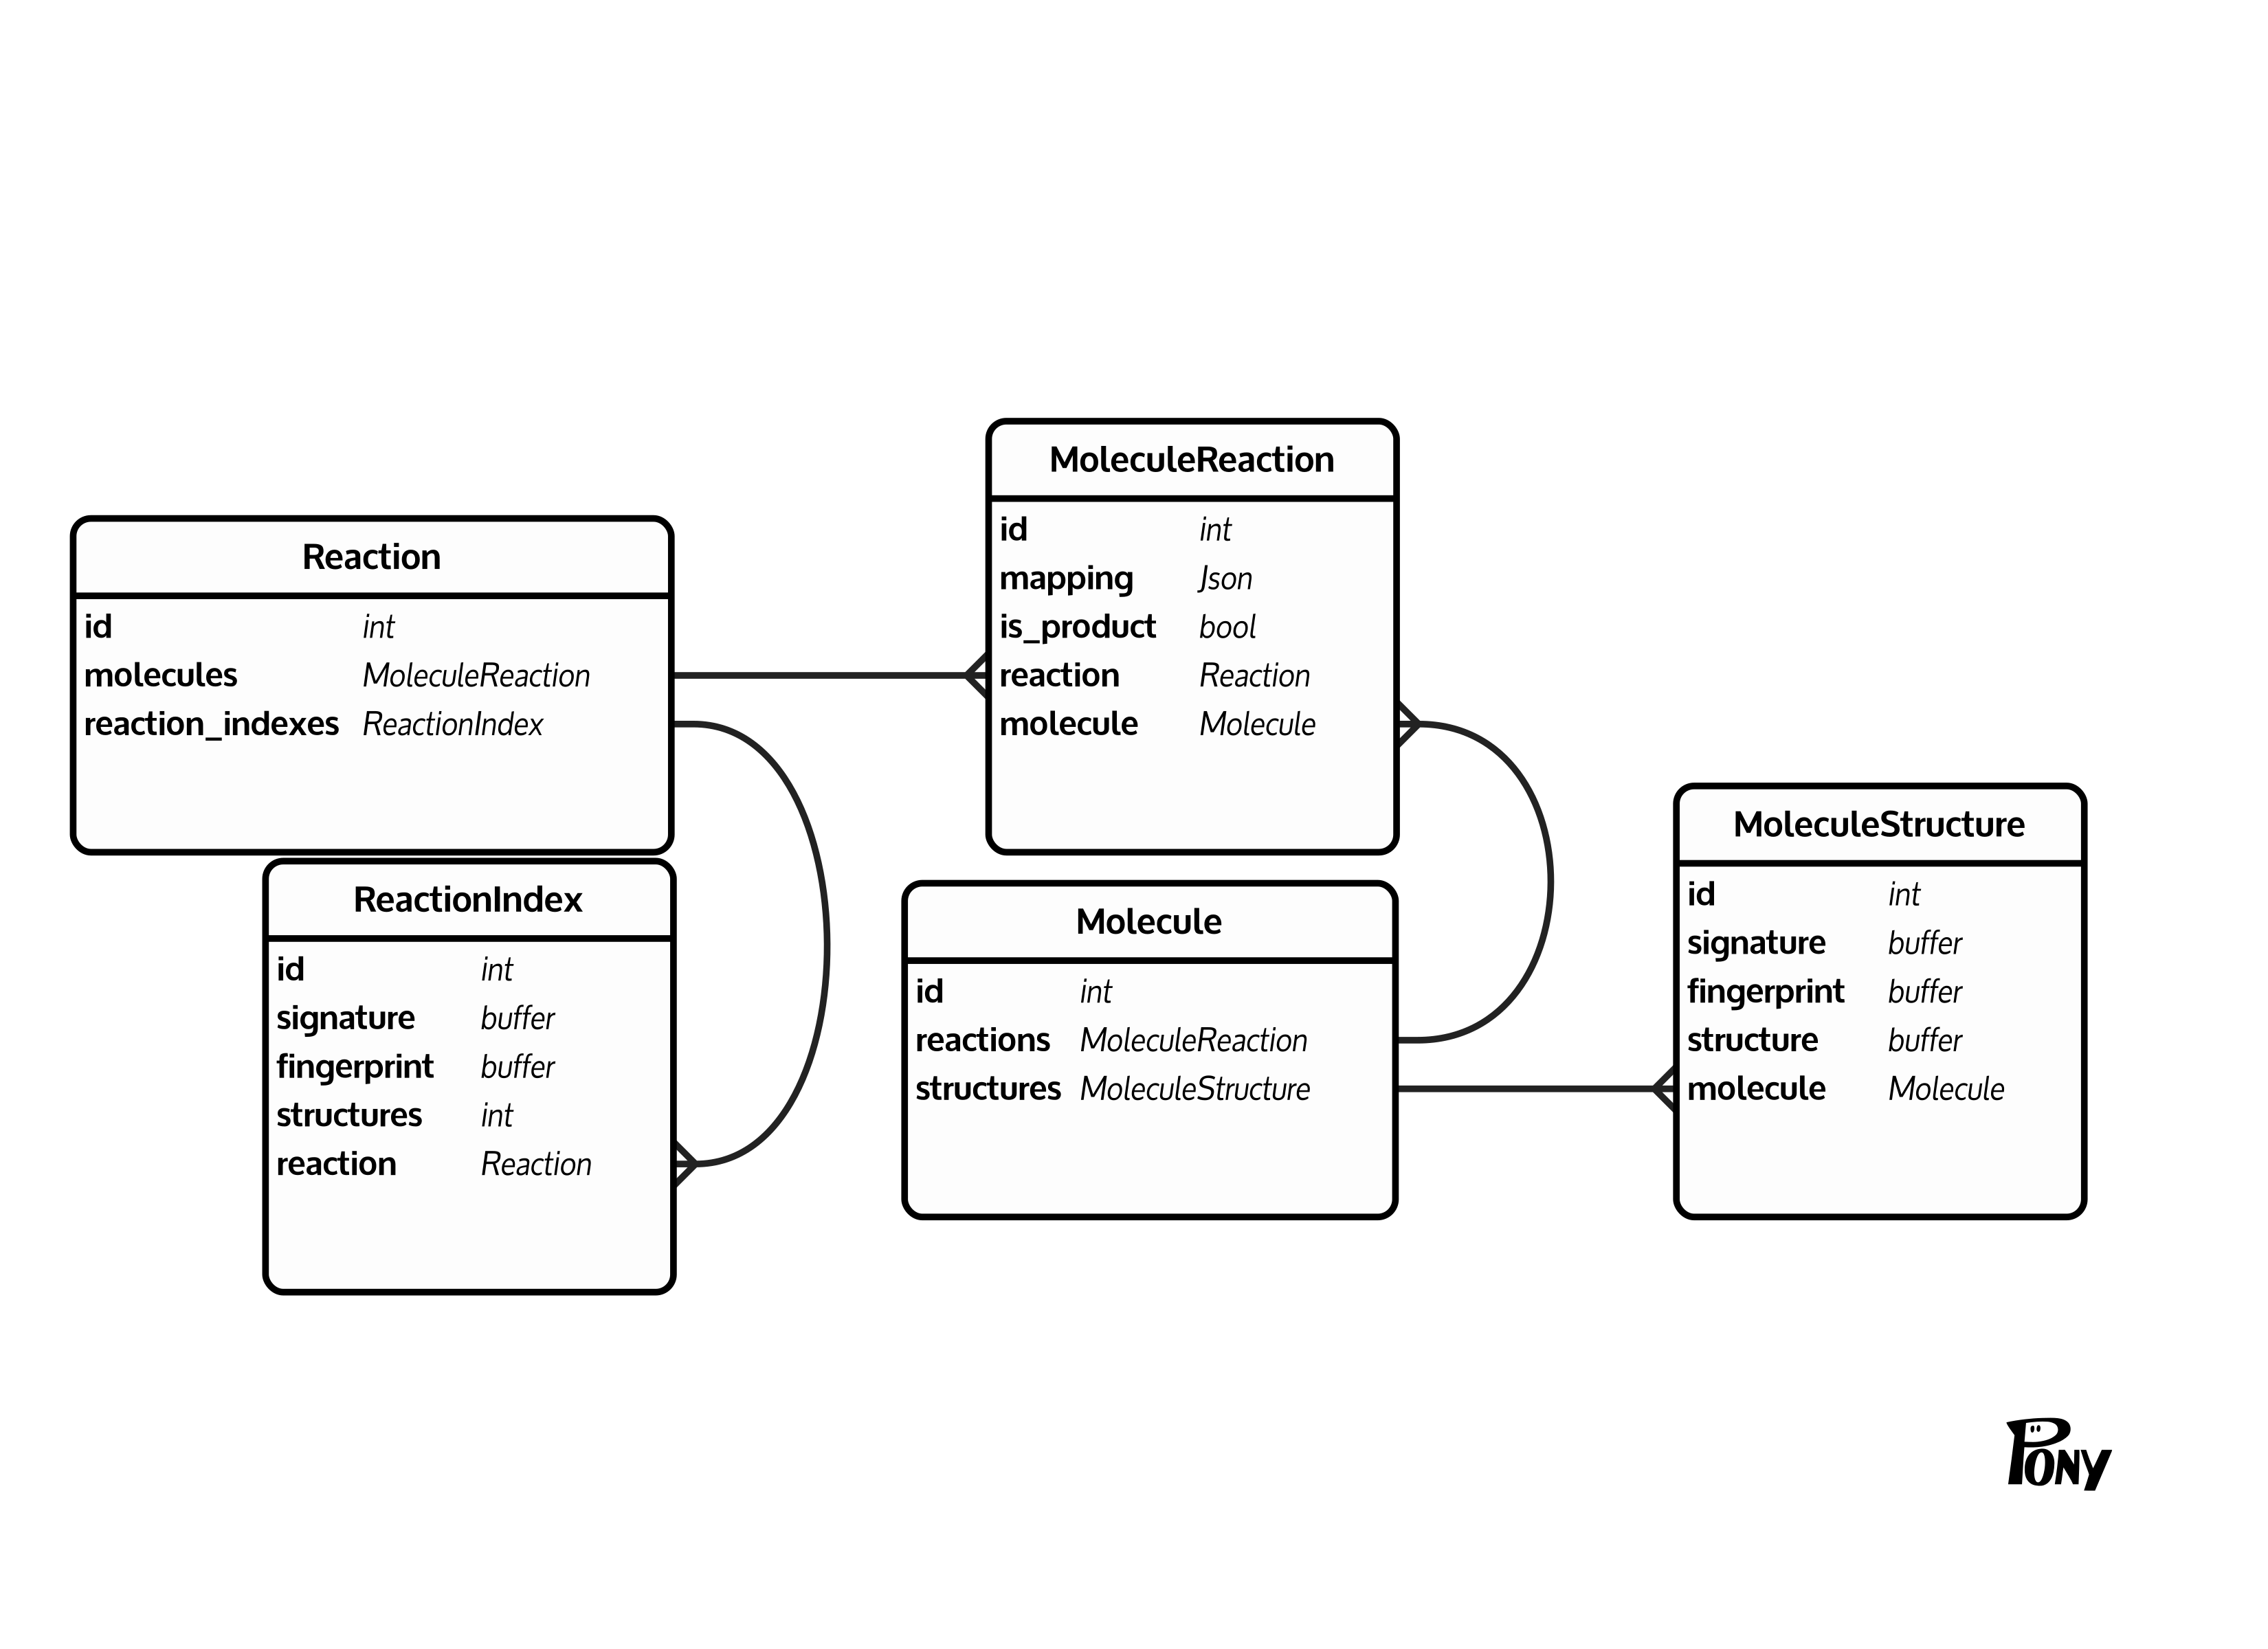

# Data storing

Load example reaction and molecule

In [3]:
reaction = next(RDFRead('example.rdf')) # load example from file
reaction

In [4]:
molecule = reaction.products[0] # get product structure from example reaction
molecule

### Storing of molecules
Only new molecules can be stored in DB. Already exists molecules will raise exception.

In [5]:
with db_session:
    m = Molecule(molecule)
m  # molecule record object

Molecule[1]

### Storing of reactions
Only new reactions can be stored in DB. Already exists reactions will raise exception.  
Note: Reactions with same molecules and different Atom-to-Atom Mappint (AAM) not equal.

In [6]:
with db_session:
    r = Reaction(reaction)
r  # reaction record object

Reaction[1]

Duplicates raise exceptions

In [7]:
try:  # try whole db_session!
    with db_session:
        m = Molecule(molecule)
except:
    print('Already in DB!')

Already in DB!


### Storing multiple molecules or rections

`[]` - is list or any iterable of molecules or reactions

In [8]:
for reaction in RDFRead('example.rdf').read()[1:]:  # example of multiple reactions storing. for molecules same approach.
    try:  # try whole db_session!
        with db_session:
            m = Reaction(reaction)
    except:
        pass

Possible storing in same db_session, but you need be sure that data is unique and not exists in DB!

In [9]:
with db_session:
    for molecule in []:  # example of multiple molecules storing. for reactions same approach.
        m = Molecule(molecule)

# Getting data from DB

Cartridge based on Pony ORM https://ponyorm.com.

The code which interacts with the database has to be placed within a database session. The session sets the borders of a conversation with the database.

Molecule and Reaction objects is only links to data stored in DB. For accessing structure data, required additional data loading. Data loading possible only in same db_session! See below for details.

## Loading data by ID
Each molecule or reaction in DB has unique autogenerated ID. Getting data by ID same as for getting data from lists, tuples or dicts.

In [10]:
with db_session:  # required
    m = Molecule[1]  # load Molecule record
m

Molecule[1]

In [11]:
with db_session:  # required
    r = Reaction[1]  # load Reaction record
r

Reaction[1]

### Structural data accsessing
By design CGRdb can store multiple molecule representations. One of them marked as canonical form.

Canonical structure information available as `.structure` attribute of Molecule or Reaction objects.  
All structures available as `.structures` attribute.

In [12]:
with db_session:
    m = Molecule[1]
    mc = m.structure  # load canonical structure of molecule. should be loaded in the same db_session!
    mcs = m.structures  # load all available structure representations of molecule

In [13]:
mc

In [14]:
mcs

(<CGRtools.containers.molecule.MoleculeContainer at 0x7fa138106b88>,)

In [15]:
mcs[0]

In [16]:
with db_session:  # required
    r = Reaction[1]
    rc = r.structure  # load reaction with canonical structures of molecules. should be loaded in the same db_session!
    rcs = r.structures  # load reactionss with all possible combinations of molecules representations.

In [17]:
rc

In [18]:
rcs

(<CGRtools.containers.reaction.ReactionContainer at 0x7fa120870e18>,)

In [19]:
rcs[0]

Once loaded Molecule or Reaction objects attributes will be cached for fast accessing. Loaded attributes available outside `db_session`.

In [20]:
r.structure  # without db_session!

# Searching
Supported next searching techniques:
* molecules:
    * exact molecule
    * substructure molecules
    * similar molecules
* reactions by molecule - same as molecule search
* reactions without AAM:
    * consists substructure molecules
* reactions with AAM - same as molecule search

In [21]:
reaction = next(RDFRead('example.rdf')) # load example from file
molecule = reaction.reactants[0] # get product structure from example reaction

In [22]:
reaction  # reaction query

In [23]:
molecule  # molecule query

In [24]:
reaction_aam = ReactionContainer([reaction.reactants[0], reaction.reactants[1].substructure([7])],
                                  [reaction.products[0].substructure([1, 7]), reaction.products[1]])
reaction_aam  # reduced reaction center

In [25]:
reaction_part = ReactionContainer([reaction.reactants[0]], [reaction.products[0].substructure([1, 7])])
reaction_part  # reduced reaction query

## Molecules searching
### Exact molecules searching

In [26]:
with db_session:
    found = Molecule.find_structure(molecule)  # Molecule object or None returned
    fs = found.structure  # db_session required if found molecule structure not canonical.
fs

### Substructure search of molecules

In [27]:
with db_session:
    found = Molecule.find_substructures(molecule)  # MoleculeSearchCache object or None returned
found

MoleculeSearchCache[1]

`MoleculeSearchCache` object is proxy-object for accessing found data. This object has `size` and provide `tanimotos` and `molecules` methods for pagination of found data.

In [28]:
len(found)  # get amount of found data

82

In [29]:
found.operator  # Get type of search

'substructure'

In [30]:
with db_session:  # possible using of separate db_session!
    molecules = found.molecules(1, 10)  # get first page with size of 10 items.

In [31]:
len(molecules)

10

In [32]:
molecules[4].structure  # For accessing structural data of canonical form db_session is not required. Data already cached!

`tanimotos` method returns tanimoto indexes between query and found molecules structures. All found molecules in found results sorted by desceding of tanimoto index.

In [33]:
with db_session:  # possible using of separate db_session!
    tanimotos = found.tanimotos(1, 10)  # get first page with size of 10 items.

In [34]:
tanimotos

[1.0, 0.6, 0.6, 0.545455, 0.5, 0.5, 0.375, 0.375, 0.375, 0.333333]

### Similarity search of molecules
Searching of molecules with similar by tanimoto structures. By default molecules is similar if tanimoto index greater than `0.6`.

In [35]:
with db_session:
    found = Molecule.find_similar(molecule)  # MoleculeSearchCache object or None returned
found

MoleculeSearchCache[2]

In [36]:
len(found)

4

In [37]:
found.operator

'similar'

In [38]:
with db_session:
    molecules = found.molecules(1)  # default page size is 100
    tanimotos = found.tanimotos(1)


In [39]:
tanimotos

[1.0, 0.714286, 0.6, 0.6]

In [40]:
molecules[2].structure

## Reaction Searching
### Exact reactions searching

In [41]:
with db_session:
    found = Reaction.find_structure(reaction)  # Reaction object or None returned

found.structure  # db_session not required for canonical structure.

### Reactions by molecule searching
This searching type is combination of molecule searching showed above and expansion of relations to reactions.

Available searching by substructure molecules and similar molecules.
#### Reactions with substructure molecules

In [42]:
with db_session:
    found = Molecule.find_substructure_reactions(molecule)  # ReactionSearchCache object or None returned
len(found)

569

In [43]:
found.operator

'substructure'

In [44]:
with db_session:  # ReactionSearchCache object is similar to MoleculeSearchCache
    reactions = found.reactions(36, 10)
    tanimotos = found.tanimotos(36, 10)  # tanimoto index between query molecule and found molecule in reaction.

In [45]:
tanimotos

[0.6, 0.6, 0.5, 0.5, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375]

In [46]:
reactions[4].structure  # db_session not required for canonical structure.

#### Possible to specify in which part of reaction molecules should be.
`is_product` keyword may be in 3 states: None - unspecified part, True - product side, False - reactants part.

In [47]:
with db_session:
    found = Molecule.find_substructure_reactions(molecule, is_product=True)
len(found)

13

In [48]:
found

ReactionSearchCache[2]

In [49]:
with db_session:
    reactions = found.reactions(1)
    tanimotos = found.tanimotos(1)

In [50]:
tanimotos

[0.545455,
 0.333333,
 0.0923077,
 0.0560748,
 0.05,
 0.046875,
 0.0377358,
 0.03,
 0.0283019,
 0.028169,
 0.0269058,
 0.0227273,
 0.0216607]

In [51]:
reactions[1].structure

#### Reactions with similar molecules

In [52]:
with db_session:
    found = Molecule.find_similar_reactions(molecule)  # API same as for find_substructure_reactions
len(found)

352

In [53]:
with db_session:
    reactions = found.reactions(30, 10)
    tanimotos = found.tanimotos(30, 10)

In [54]:
tanimotos

[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]

In [55]:
reactions[0].structure

### Reactions by reaction without AAO searching
Found reactions match all molecules from query reaction. Only substructured search available.

In [56]:
reaction_part  # Query. Expected substitution.

In [57]:
with db_session:
    found = Reaction.find_mappingless_substructures(reaction_part)
len(found)

368

In [58]:
with db_session:
    reactions = found.reactions(35, 10)
    tanimotos = found.tanimotos(35, 10)

In [59]:
tanimotos  # tanimoto is mean of tanimotos of all found molecules

[0.0682077,
 0.0681176,
 0.065625,
 0.0534615,
 0.0516509,
 0.0506699,
 0.0479941,
 0.0454572,
 0.0451128,
 0.0451128]

In [60]:
reactions[9].structure

### Reactions by reaction with AAO searching

Used CGR approach. Available `substructure` and `similarity` search.
#### Substructure of reaction center

In [61]:
with db_session:
    found = Reaction.find_substructures(reaction_aam)
len(found)

334

In [62]:
with db_session:
    reactions = found.reactions(1, 10)
    tanimotos = found.tanimotos(1, 10)

In [63]:
tanimotos

[1.0,
 0.666667,
 0.631579,
 0.6,
 0.461538,
 0.461538,
 0.444444,
 0.333333,
 0.324324,
 0.324324]

In [64]:
reactions[9].structure